### Importing Data

In [1]:
pip install pyspark

     |████████████████████████████████| 212.4MB 63kB/s 
     |████████████████████████████████| 204kB 16.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=d8dcedc6b6de0bb3aea84f973ac6feb099b3bf26980ca00b44bc098ae679c120
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
pip install handyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.regression import RandomForestRegressor, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from handyspark import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Loading Data and Exploratory Data Analysis

In [23]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [34]:
data = sc.read.csv("/content/drive/MyDrive/Big Data Pyspark/data.csv", header=True, inferSchema=True)

In [35]:
data.printSchema()
data.describe().toPandas().T

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11914,None,None,Acura,Volvo
Model,11914,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11914,2010.384337753903,7.5797398875957995,1990,2017
Engine Fuel Type,11911,None,None,diesel,regular unleaded
Engine HP,11845,249.38607007176023,109.19187025917194,55,1001
Engine Cylinders,11884,5.628828677213059,1.78055934824622,0,16
Transmission Type,11914,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11914,None,None,all wheel drive,rear wheel drive
Number of Doors,11908,3.4360933825999327,0.8813153865835529,2,4


Market Category columns has different data sctructure. I will replace N/A with None values and we will be able to see the null value count.

In [36]:
def replace(column, value):
    return when(column != value, column).otherwise(lit(None))

data = data.withColumn("Market Category", replace(col("Market Category"), "N/A"))

In [37]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|Make|Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|Driven_Wheels|Number of Doors|Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|MSRP|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|   0|    0|   0|               3|       69|              30|                0|            0|              6|           3742|           0|            0|          0|       0|         0|   0|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+



In [38]:
print("Row Count Before Drop:", data.count(), "Column Count Before Drop:", len(data.columns))
data = data.drop("Market Category")
data = data.na.drop()
print("Row Count After Drop:", data.count(), "Column Count After Drop:", len(data.columns))

Row Count Before Drop: 11914 Column Count Before Drop: 16
Row Count After Drop: 11812 Column Count After Drop: 15


I want to see the outliers and distribution of data. So that, I convert pyspark dataframe into pandas dataframe. We can use HandySpark plotting for pysapark. However, I had problems while creating boxplot due to pyspark version on my computer.

In [11]:
df = data.toPandas()

In [12]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,18,3916,34500


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11812 entries, 0 to 11811
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Make               11812 non-null  object
 1   Model              11812 non-null  object
 2   Year               11812 non-null  int32 
 3   Engine Fuel Type   11812 non-null  object
 4   Engine HP          11812 non-null  int32 
 5   Engine Cylinders   11812 non-null  int32 
 6   Transmission Type  11812 non-null  object
 7   Driven_Wheels      11812 non-null  object
 8   Number of Doors    11812 non-null  int32 
 9   Vehicle Size       11812 non-null  object
 10  Vehicle Style      11812 non-null  object
 11  highway MPG        11812 non-null  int32 
 12  city mpg           11812 non-null  int32 
 13  Popularity         11812 non-null  int32 
 14  MSRP               11812 non-null  int32 
dtypes: int32(8), object(7)
memory usage: 1015.2+ KB


### Data Visualization and Outlier Detection

Handy Spark Representation

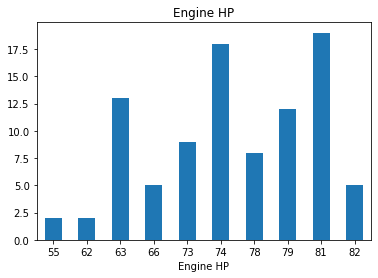

In [14]:
hdf = data.toHandy()
hdf.cols["Engine HP"].hist()

#### Numeric Columns

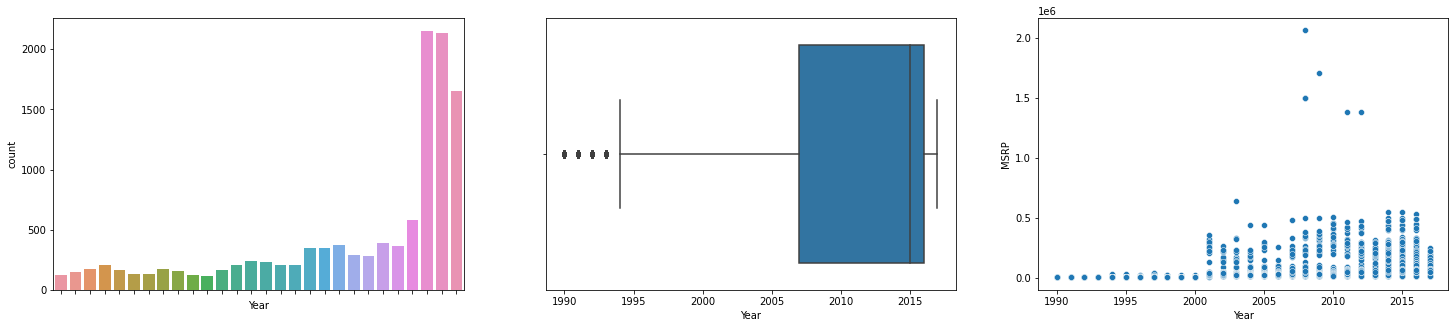

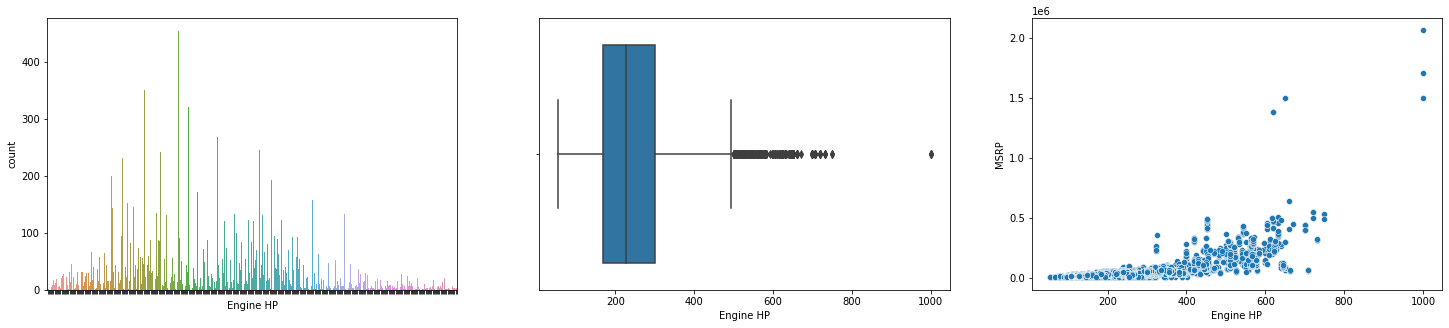

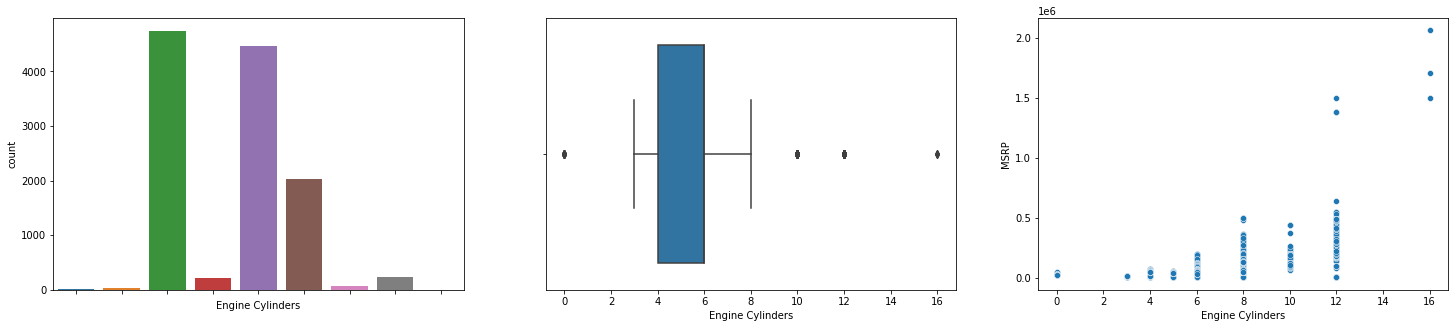

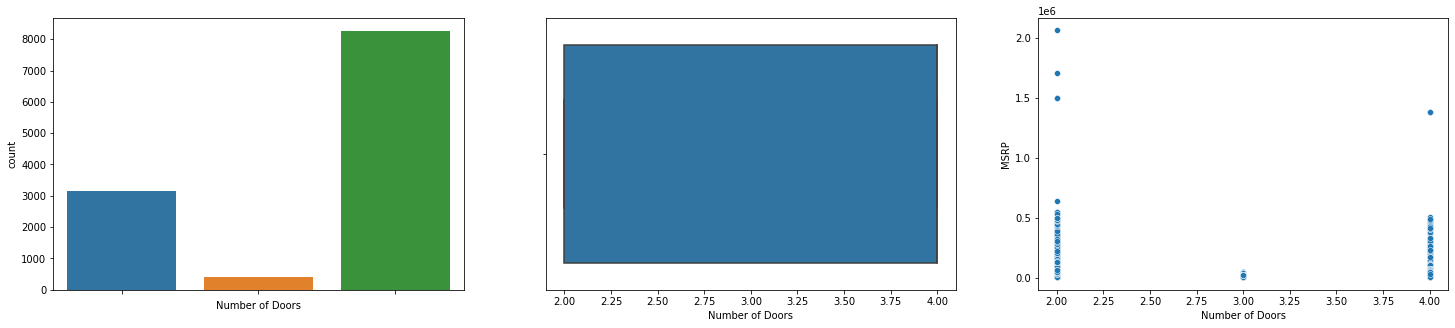

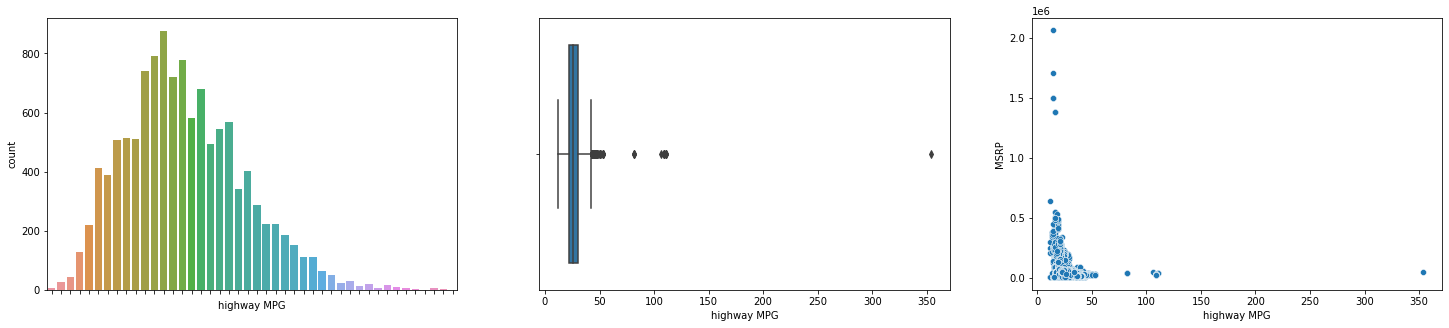

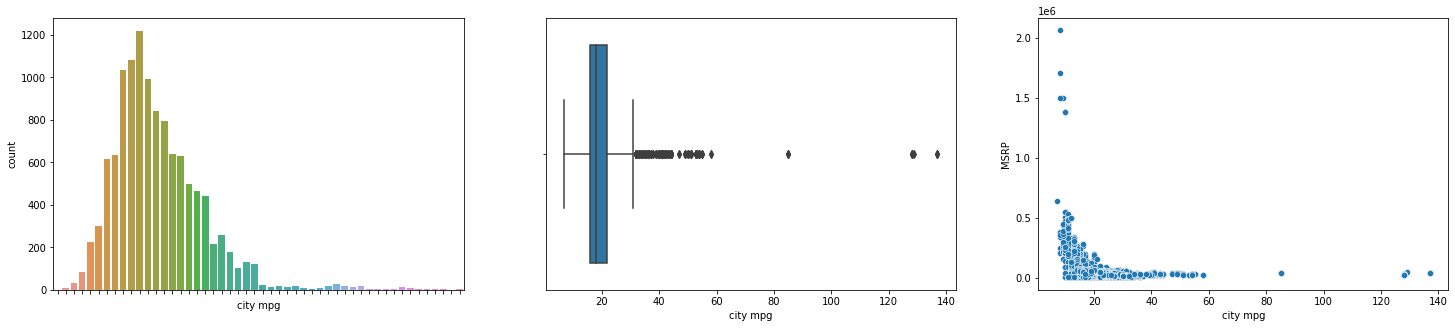

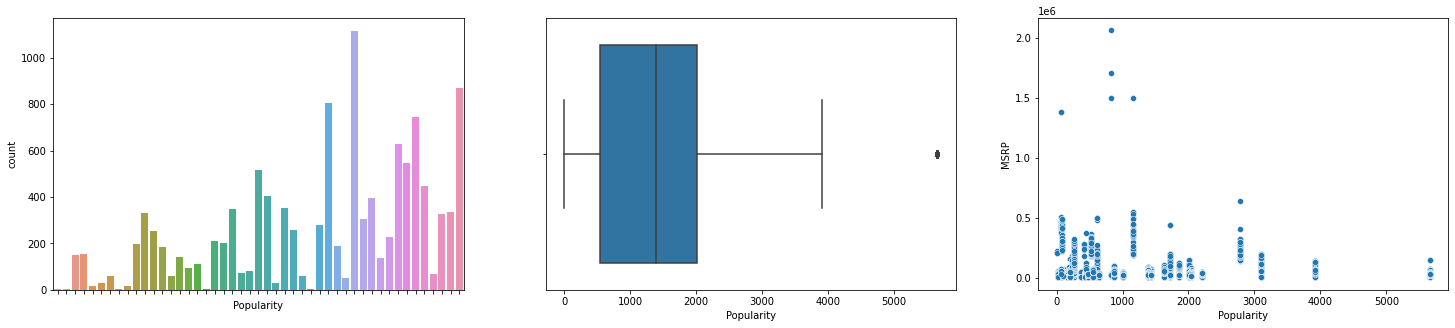

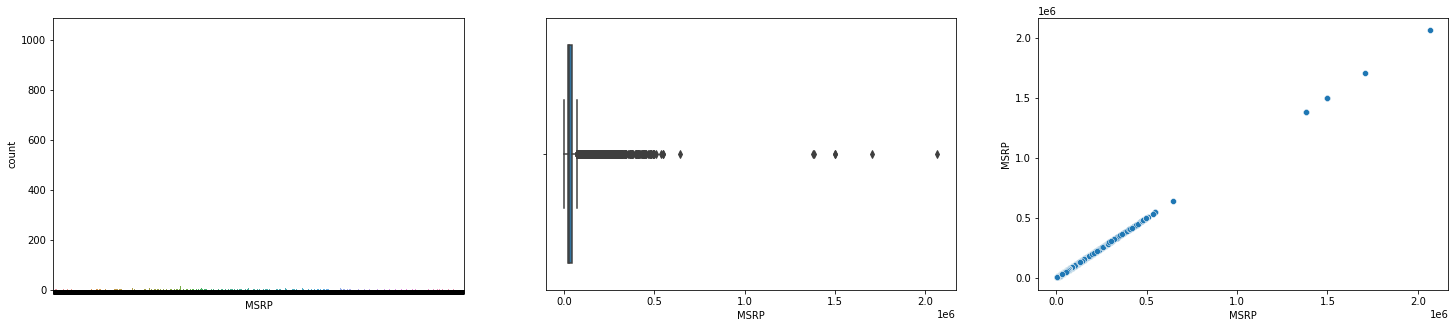

In [27]:
def numeric_plots(df):
    for i in df.columns:
        if df[i].dtype != "object":
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
            g = sns.countplot(df[i], ax=ax[0])
            g.set_xticklabels([])
            sns.boxplot(df[i], ax=ax[1])
            sns.scatterplot(y="MSRP", x=i, data=df, ax=ax[2])
            plt.show()

numeric_plots(df)

##### 1. Engine HP

In [28]:
data.filter(data["engine HP"] > 800).show()

+-------+-----------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|   Make|      Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|  Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|   MSRP|
+-------+-----------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|Bugatti|Veyron 16.4|2008|premium unleaded ...|     1001|              16| AUTOMATED_MANUAL|all wheel drive|              2|     Compact|        Coupe|         14|       8|       820|2065902|
|Bugatti|Veyron 16.4|2008|premium unleaded ...|     1001|              16| AUTOMATED_MANUAL|all wheel drive|              2|     Compact|        Coupe|         14|       8|       820|1500000|
|Bugatti|Veyron 16.4|2009|premium unlead

When we search for Domain Knowledge, Bugatti Veyron has high engine horsepower. So that there will be no special treatmen for this outlier.

##### 2. Engine Cylinders

In [29]:
data.filter(data["Engine Cylinders"] < 3).count()

13

In [30]:
data.filter(data["Engine Cylinders"] < 3).show()

+-------------+--------------------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|         Make|               Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+-------------+--------------------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Mercedes-Benz|B-Class Electric ...|2015|        electric|      177|               0|     DIRECT_DRIVE|front wheel drive|              4|     Compact|4dr Hatchback|         82|      85|       617|41450|
|Mercedes-Benz|B-Class Electric ...|2016|        electric|      177|               0|     DIRECT_DRIVE|front wheel drive|              4|     Compact|4dr Hatchback|         82|      85|   

In [35]:
data.filter(data["Engine Fuel Type"] == "electric").show(50)

+-------------+--------------------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|         Make|               Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+-------------+--------------------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Mercedes-Benz|B-Class Electric ...|2015|        electric|      177|               0|     DIRECT_DRIVE|front wheel drive|              4|     Compact|4dr Hatchback|         82|      85|       617|41450|
|Mercedes-Benz|B-Class Electric ...|2016|        electric|      177|               0|     DIRECT_DRIVE|front wheel drive|              4|     Compact|4dr Hatchback|         82|      85|   

All the cars whose cylinder count is less than 3, has 0 cylinder. They are electric-powered cars.

In [36]:
data.filter(data["Engine Cylinders"] > 8).groupby(["Make", "Model"]).count().show()

+-------------+--------------------+-----+
|         Make|               Model|count|
+-------------+--------------------+-----+
|  Rolls-Royce|Phantom Drophead ...|    3|
| Aston Martin|       V12 Vantage S|    3|
| Aston Martin|        V12 Vanquish|    4|
|      Maybach|                  57|    7|
|      Ferrari|                Enzo|    1|
|      Bentley|     Continental GTC|    3|
| Aston Martin|                 DBS|   16|
| Aston Martin|                 DB7|    4|
|         Audi|                  A8|    1|
|         Audi|                  R8|   17|
|  Rolls-Royce|           Park Ward|    2|
|          BMW|            7 Series|    1|
|Mercedes-Benz|            SL-Class|    3|
|        Dodge|               Viper|   14|
|      Bentley|Continental GT Speed|    2|
|      Bugatti|         Veyron 16.4|    3|
|      Ferrari|                  FF|    2|
|Mercedes-Benz|             G-Class|    1|
|  Rolls-Royce|       Phantom Coupe|    3|
|  Lamborghini|             Huracan|    4|
+----------

In [37]:
data.filter(data["Engine Cylinders"] > 8).show(10)

+-------+-----+----+--------------------+---------+----------------+-----------------+----------------+---------------+------------+-------------+-----------+--------+----------+------+
|   Make|Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|   Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|  MSRP|
+-------+-----+----+--------------------+---------+----------------+-----------------+----------------+---------------+------------+-------------+-----------+--------+----------+------+
|Ferrari| 456M|2001|premium unleaded ...|      442|              12|        AUTOMATIC|rear wheel drive|              2|     Compact|        Coupe|         14|       9|      2774|223970|
|Ferrari| 456M|2001|premium unleaded ...|      442|              12|           MANUAL|rear wheel drive|              2|     Compact|        Coupe|         15|       9|      2774|219775|
|Ferrari| 456M|2002|premium unleaded ...|      442|              12|  

It can be understood from the domain research that these cars have more than 8 cylinders. There will be no specific dropping for this column.

##### 3. Highway MPG

In [39]:
data.filter(data["highway MPG"] > 300).show()

+----+-----+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Make|Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+-----+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Audi|   A6|2017|premium unleaded ...|      252|               4| AUTOMATED_MANUAL|front wheel drive|              4|     Midsize|        Sedan|        354|      24|      3105|51600|
+----+-----+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+



When we search for Domain knowledge, 2017 Audi A6 has 29 MPG in highways. We can treat that outliers by removing the row.

In [40]:
data = data.filter(data["highway MPG"] < 300)

##### 4. City MPG

In [40]:
data.filter(data["city MPG"] > 100).show()

+---------+--------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|     Make|   Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+---------+--------+----+----------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|      BMW|      i3|2015|        electric|      170|               0|     DIRECT_DRIVE| rear wheel drive|              4|     Compact|4dr Hatchback|        111|     137|      3916|42400|
|      BMW|      i3|2016|        electric|      170|               0|     DIRECT_DRIVE| rear wheel drive|              4|     Compact|4dr Hatchback|        111|     137|      3916|42400|
|      BMW|      i3|2017|        electric|      170|             

When we search for Domain Knowledge on city MPG, BMW i3 and Chevrolet Spark EV has high city MPG. There will be no special treatment.

##### 5. MSRP

In [41]:
data.filter(data["MSRP"] > 1000000).groupby(["Make", "Model"]).count().show()

+-----------+-----------+-----+
|       Make|      Model|count|
+-----------+-----------+-----+
|    Bugatti|Veyron 16.4|    3|
|Lamborghini|   Reventon|    1|
|    Maybach|  Landaulet|    2|
+-----------+-----------+-----+



In [42]:
data.filter(data["MSRP"] > 1000000).count()

6

In [43]:
data.filter(data["Make"] == "Bugatti").show()

+-------+-----------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|   Make|      Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|  Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|   MSRP|
+-------+-----------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|Bugatti|Veyron 16.4|2008|premium unleaded ...|     1001|              16| AUTOMATED_MANUAL|all wheel drive|              2|     Compact|        Coupe|         14|       8|       820|2065902|
|Bugatti|Veyron 16.4|2008|premium unleaded ...|     1001|              16| AUTOMATED_MANUAL|all wheel drive|              2|     Compact|        Coupe|         14|       8|       820|1500000|
|Bugatti|Veyron 16.4|2009|premium unlead

In [44]:
data.filter((data["Make"] == "Lamborghini") & (data["Model"] == "Reventon")).show()

+-----------+--------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|       Make|   Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|  Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|   MSRP|
+-----------+--------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+
|Lamborghini|Reventon|2008|premium unleaded ...|      650|              12| AUTOMATED_MANUAL|all wheel drive|              2|     Compact|        Coupe|         14|       9|      1158|1500000|
+-----------+--------+----+--------------------+---------+----------------+-----------------+---------------+---------------+------------+-------------+-----------+--------+----------+-------+



In [45]:
data.filter((data["Make"] == "Maybach") & (data["Model"] == "Landaulet")).show()

+-------+---------+----+--------------------+---------+----------------+-----------------+----------------+---------------+------------+-------------+-----------+--------+----------+-------+
|   Make|    Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|   Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|   MSRP|
+-------+---------+----+--------------------+---------+----------------+-----------------+----------------+---------------+------------+-------------+-----------+--------+----------+-------+
|Maybach|Landaulet|2011|premium unleaded ...|      620|              12|        AUTOMATIC|rear wheel drive|              4|       Large|  Convertible|         16|      10|        67|1380000|
|Maybach|Landaulet|2012|premium unleaded ...|      620|              12|        AUTOMATIC|rear wheel drive|              4|       Large|  Convertible|         16|      10|        67|1382750|
+-------+---------+----+--------------------+

Cars with special brand and model have high MSRP. Their numbers are queit a few and they can effect our model with MSRP and their affect on other features. MSRP with more than 1000000 will be dropped.

In [41]:
data = data.filter(data["MSRP"] < 1000000)

#### Categoric Columns

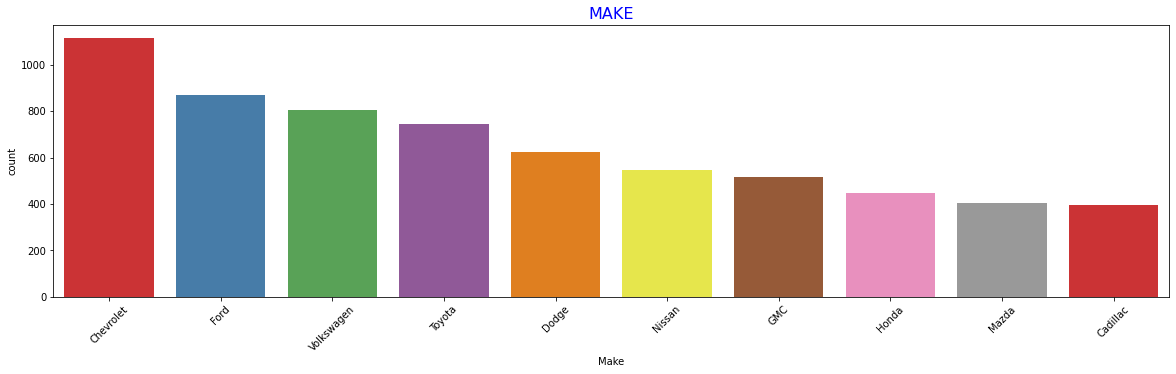

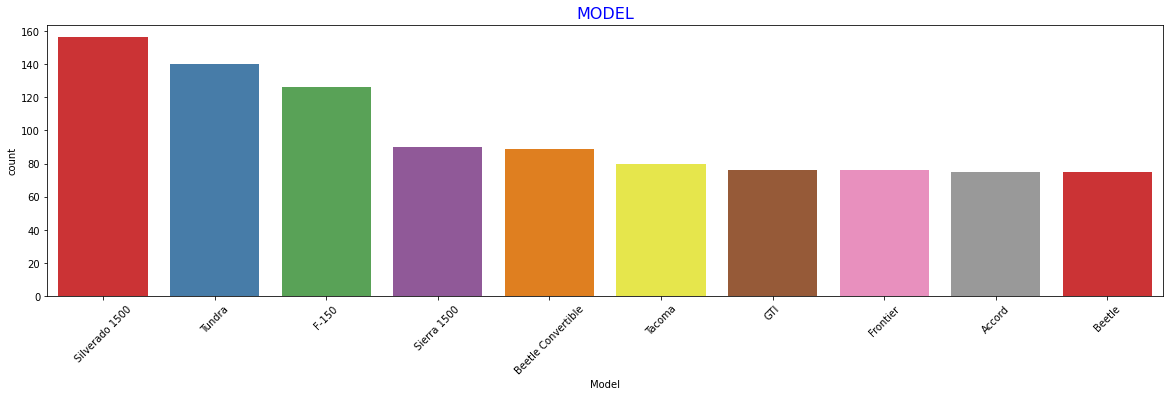

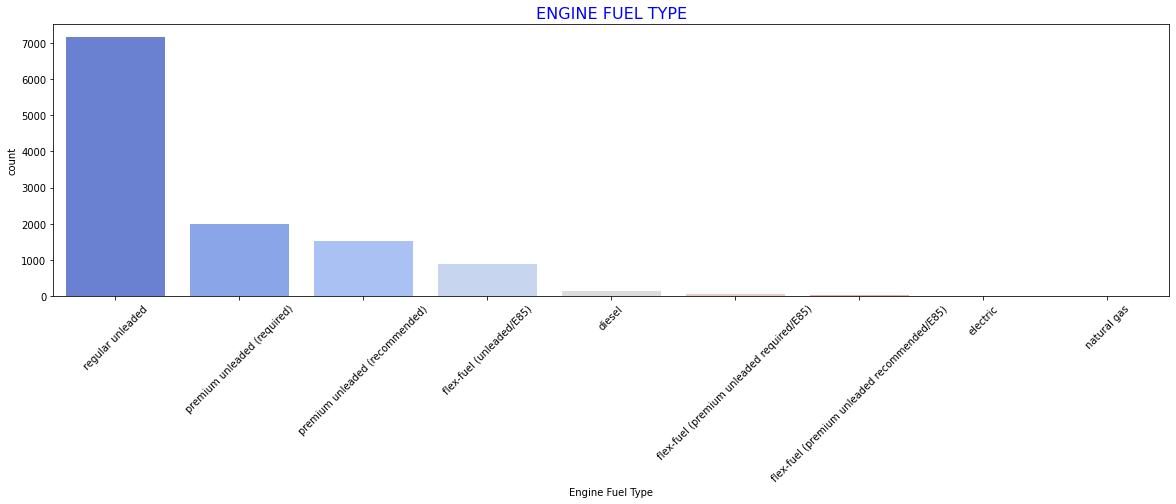

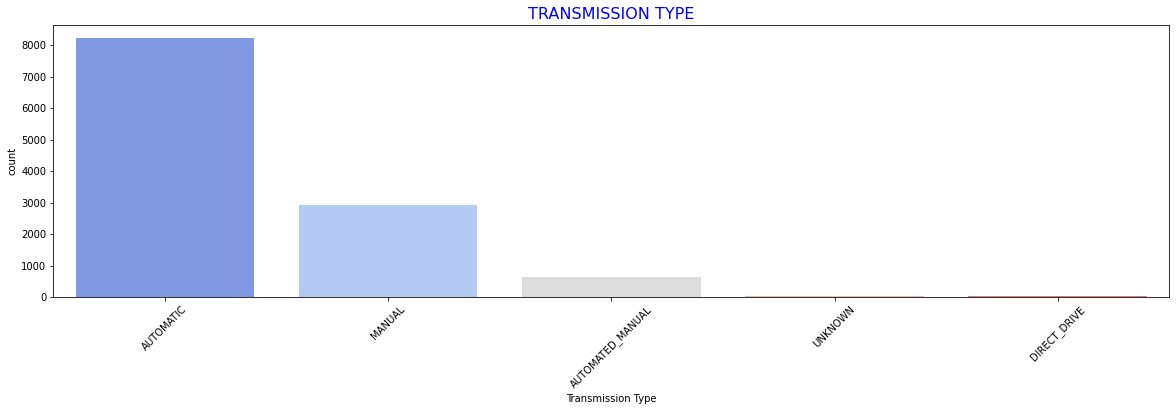

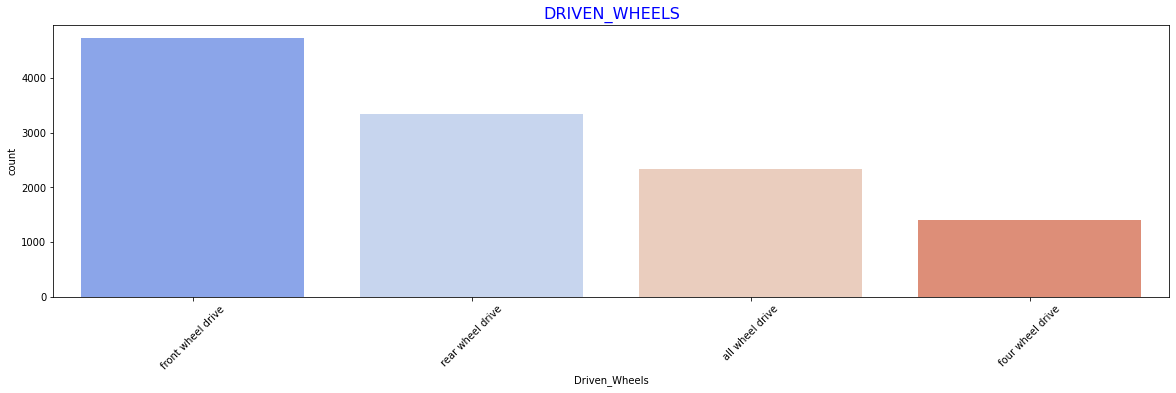

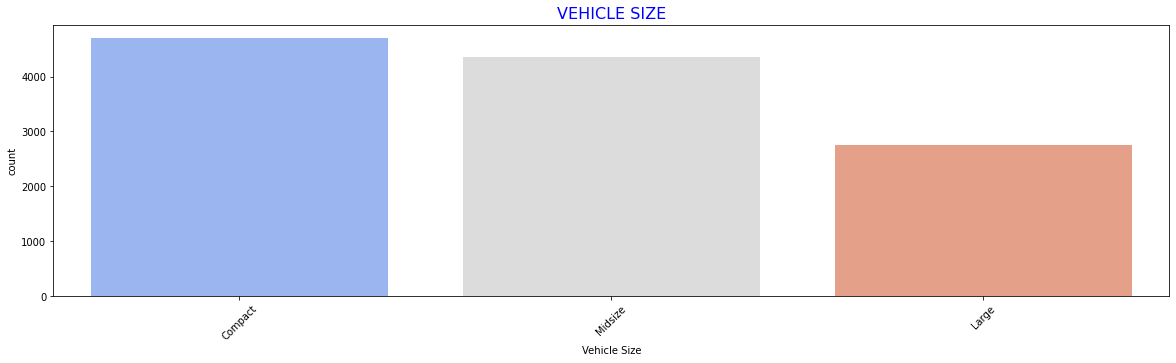

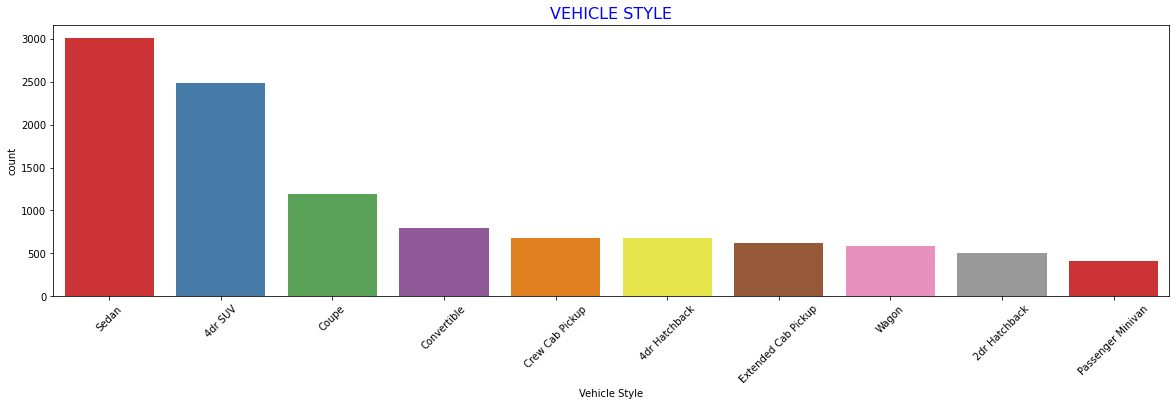

In [42]:
def categoric_plots(df):
    for i in df.columns:
        if df[i].dtype == "object":
            if df[i].nunique() > 10:
                plt.figure(figsize=(20,5))
                plt.title(i.upper(), c="blue", size=16)
                sns.countplot(df[i], order=df[i].value_counts().index[:10], palette="Set1")
                plt.xticks(rotation=45)
                plt.show()
            else:
                plt.figure(figsize=(20,5))
                plt.title(i.upper(), c="blue", size=16)
                sns.countplot(df[i], order=df[i].value_counts().index, palette="coolwarm")
                plt.xticks(rotation=45)
                plt.show()
categoric_plots(df)

In [48]:
data.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11805,None,None,Acura,Volvo
Model,11805,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11805,2010.3615417196104,7.596531940381738,1990,2017
Engine Fuel Type,11805,None,None,diesel,regular unleaded
Engine HP,11805,249.21660313426514,108.41019171048914,55,750
Engine Cylinders,11805,5.645319779754342,1.7413667067195746,0,12
Transmission Type,11805,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11805,None,None,all wheel drive,rear wheel drive
Number of Doors,11805,3.432867429055485,0.8827408449347032,2,4


### Building Model

#### Creating Pipeline

In [55]:
string_indexer = StringIndexer(inputCols=["Make", "Engine Fuel Type", "Transmission Type", "Driven_Wheels", 
                                          "Vehicle Size", "Vehicle Style"], 
                               outputCols=["Make_ind", "Engine Fuel Type_ind", "Transmission Type_ind", "Driven_Wheels_ind", 
                                           "Vehicle Size_ind", "Vehicle Style_ind"], handleInvalid="keep")

ohe_indexer = OneHotEncoder(inputCols=["Make_ind", "Engine Fuel Type_ind", "Transmission Type_ind", "Driven_Wheels_ind", 
                                       "Vehicle Size_ind", "Vehicle Style_ind"], 
                           outputCols=["Make_ohe", "Engine Fuel Type_ohe", "Transmission Type_ohe", "Driven_Wheels_ohe", 
                                       "Vehicle Size_ohe", "Vehicle Style_ohe"], handleInvalid="keep")

assembler = VectorAssembler(inputCols=["Year", "Engine HP", "Engine Cylinders", "Number of Doors", "highway MPG", 
                                       "city mpg", "Popularity", "Make_ohe", "Engine Fuel Type_ohe", "Transmission Type_ohe", 
                                       "Driven_Wheels_ohe", "Vehicle Size_ohe", "Vehicle Style_ohe"] , outputCol="Attributes")

regressor = RandomForestRegressor(featuresCol="Attributes", labelCol="MSRP")

pipeline = Pipeline(stages=[string_indexer, ohe_indexer, assembler, regressor])

#### Creating Cross Validator

In [56]:
paramgrid = ParamGridBuilder() \
                .addGrid(regressor.numTrees, [50, 100, 500, 1000]).build()

cross_validator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramgrid,
                                evaluator= RegressionEvaluator(labelCol="MSRP"),
                                numFolds=3)

In [57]:
train_data, test_data = data.randomSplit([0.75, 0.25], seed=1)
cvmodel = cross_validator.fit(train_data)

#### Best Model and Assesment

In [58]:
bestmodel = cvmodel.bestModel
for x in range(len(bestmodel.stages)):
    print(bestmodel.stages[x])

StringIndexerModel: uid=StringIndexer_a13aca89b200, handleInvalid=keep, numInputCols=6, numOutputCols=6
OneHotEncoderModel: uid=OneHotEncoder_76460396f039, dropLast=true, handleInvalid=keep, numInputCols=6, numOutputCols=6
VectorAssembler_f5b3ef9f04f2
RandomForestRegressionModel: uid=RandomForestRegressor_85fdfc350bc3, numTrees=500, numFeatures=96


In [59]:
pred = cvmodel.transform(test_data)
pred.select("MSRP", "prediction").show()

+-----+------------------+
| MSRP|        prediction|
+-----+------------------+
|28200| 38178.40950965672|
|27900|30576.150049140666|
|29200|30576.150049140666|
|29900|30576.150049140666|
|32900|30576.150049140666|
| 2827| 6277.047289034246|
| 3381| 6545.290928318202|
| 3086| 6091.416193652318|
| 3012| 6278.361238572272|
| 7398|6330.0423668694975|
|24450| 34296.96759679103|
|20200| 23390.79576415564|
|21850| 23390.79576415564|
| 2000| 5754.826569352031|
| 2000| 5462.800856046002|
| 2181| 5463.203442049034|
| 2506| 5482.570090064581|
|56780| 39437.18914584103|
|54780| 37548.15965250187|
|45015| 39437.18914584103|
+-----+------------------+
only showing top 20 rows



In [60]:
eval = RegressionEvaluator(labelCol="MSRP")
rmse = eval.evaluate(pred)
mse = eval.evaluate(pred, {eval.metricName:"mse"})
mae = eval.evaluate(pred, {eval.metricName:"mae"})
r2 = eval.evaluate(pred, {eval.metricName:"r2"})

print("RMSE: %.3f" %rmse)
print("MSE : %.3f" %mse)
print("MAE : %.3f" %mae)
print("R2  : %.3f" %r2)

RMSE: 16879.036
MSE : 284901871.649
MAE : 8088.879
R2  : 0.886
